Autor: Ronald Guiuseppi Ramírez Nina

Doutando no Insitutto de Astronomia Geofísica e Ciências Atmosféricas na Universidade de São Paulo

**Códigos elaborados em Python para a disciplina de Meteorología Sinótica**

Adaptado de Camila Lopes

**1. Instalando o ambiente Anaconda**

In [1]:
# Instalando conda (mamba)
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:18
🔁 Restarting kernel...


**2. Instalando as livrarias**

In [2]:
# Instalando pacotes necessários
!mamba install -c conda-forge cartopy siphon metpy imgaug
!apt-get -qq install libproj-dev libgeos-dev
!pip uninstall shapely -y
!pip install shapely --no-binary shapely
!pip install pyyaml==5.4.1


Looking for: ['cartopy', 'siphon', 'metpy', 'imgaug']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   6%
conda-forge/noarch    14%[+] 0.3s
conda-forge/linux-64  15%
conda-forge/noarch    36%[+] 0.4s
conda-forge/linux-64  24%
conda-forge/noarch    58%[+] 0.5s
conda-forge/linux-64  24%
conda-forge/noarch    58%[+] 0.6s
conda-forge/linux-64  24%
conda-forge/noarch    69%[+] 0.7s
conda-forge/linux-64  29%
conda-forge/noarch    80%[+] 0.8s
conda-forge/linux-64  34%
conda-forge/noarch    80%[+] 0.9s
conda-forge/linux-64  38%
conda-forge/noarch    91%conda-forge/noarch                                
[+] 1.0s
conda-forge/linux-64  43%[+] 1.1s
conda-forge/linux-64  48%[+] 1.2s
conda-forge/linux-64  66%[+] 1.3s
conda-forge/linux-64  76%[+] 1.4s
conda-forge/linux-64  85%conda-forge/linux-64                              

Pinned packages:
  - python 3.10.*
  - python 3.10.*
  - python_abi 3.10.* *cp310*
  - cuda-version 12.*


Transaction

  

**3. Importando as livrarias**

In [1]:
# A whole bunch of imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import patheffects
import matplotlib.pyplot as plt
from netCDF4 import num2date
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
from siphon.catalog import TDSCatalog
import xarray as xr
from datetime import datetime
import numpy as np
import numpy.ma as ma
from metpy.io import GiniFile
from metpy.plots.ctables import registry
from metpy.units import units
import metpy.calc as mpcalc

**4. Baixando os dados, configurando o nível isobárico, os límites na longitude e latitude, e os campos meteorlógicos**

In [16]:
dt = datetime(2024, 6, 5, 12)

# Assemble our URL to the THREDDS Data Server catalog,
# and access our desired dataset within via NCSS
#https://thredds-jumbo.unidata.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/
#GFS_Global_0p25deg_20210630_0000.grib2/catalog.html?dataset=grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20210630_0000.grib2
#base_url = 'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_onedeg_ana/GFS_Global_onedeg_ana_'
#cat = TDSCatalog(f'{base_url}{dt:%Y%m%d}_{dt:%H}00.grib2/catalog.xml')
base_url = 'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg_ana/GFS_Global_0p25deg_ana_'
cat = TDSCatalog(f'{base_url}{dt:%Y%m%d}_{dt:%H}00.grib2/catalog.xml')
ncss = cat.datasets[0].subset()

# Setando
nivel = 250
lat_sul = -67.5 #-70
lat_norte = 30 #15
lon_leste = 360
lon_oeste = 230
lon_l = lon_leste - 360
lon_o = lon_oeste - 360

# level wind components data
query_wind = ncss.query()
query_wind.variables('u-component_of_wind_isobaric',
                     'v-component_of_wind_isobaric').add_lonlat().accept('netcdf')
query_wind.vertical_level(nivel * 100)
query_wind.lonlat_box(north=lat_norte, south=lat_sul, east=lon_leste, west=lon_oeste)
data_wind = ncss.get_data(query_wind)

# Z nivel
query_hght = ncss.query()
query_hght.variables('Geopotential_height_isobaric').add_lonlat().accept('netcdf')
query_hght.vertical_level(nivel * 100)
query_hght.lonlat_box(north=lat_norte, south=lat_sul, east=lon_leste, west=lon_oeste)
data_hght = ncss.get_data(query_hght)

# Z nivel
query_tmp = ncss.query()
query_tmp.variables('Temperature_isobaric').add_lonlat().accept('netcdf')
query_tmp.vertical_level(nivel * 100)
query_tmp.lonlat_box(north=lat_norte, south=lat_sul, east=lon_leste, west=lon_oeste)
data_tmp = ncss.get_data(query_tmp)

**5. Configurando o formato da longitude na forma de -180º +180º**

In [17]:
# Tem que fazer esta alteração para conseguir plotar o vento
lon =  data_hght.variables['longitude'][:]
for i in range(len(lon)):
    if lon[i]>180:
        lon[i] = lon[i]-360

**6. Estabelecendo unidades e os campos meteorológicos às diferentes variáveis**

In [18]:
# Grab variables and smooth, use MetPy Units module for conversion
#emsl_var = data_mslp.variables['Pressure_reduced_to_MSL_msl']
#EMSL = units.Quantity(emsl_var[:], emsl_var.units).to('hPa')
#mslp = gaussian_filter(EMSL[0], sigma=1.0)

uwnd_nivel = data_wind.variables['u-component_of_wind_isobaric'][:].squeeze()
vwnd_nivel = data_wind.variables['v-component_of_wind_isobaric'][:].squeeze()
hght = data_hght.variables['Geopotential_height_isobaric'][:].squeeze()
tmp = data_tmp.variables['Temperature_isobaric'][:].squeeze()

U_nivel = units('m/s') * ndimage.gaussian_filter(uwnd_nivel, sigma=1, order=0)
V_nivel = units('m/s') * ndimage.gaussian_filter(vwnd_nivel, sigma=1, order=0)
Z = units.meter * ndimage.gaussian_filter(hght, sigma=1, order=0)
T = units.kelvin * ndimage.gaussian_filter(tmp, sigma=1, order=0)

#lon = data_hght.variables['lon'][:]
lat = data_hght.variables['latitude'][:]
time = data_hght.variables[data_hght.variables['Geopotential_height_isobaric'].dimensions[0]]
vtime = num2date(time[:], time.units)

**7. Calculando a velocidade do vento**

In [19]:
# Use MetPy to calculate the wind speed for colorfill plot, change units to knots from m/s
speed_jet = mpcalc.wind_speed(U_nivel, V_nivel)

#Quero somente os valores maiores que 15 m/s
mask_jet = ma.masked_less_equal(speed_jet, 30).mask
speed_jet[mask_jet] = np.nan

**8. Calculando a Temperatura potencial**

In [20]:
# Calculate and smooth 1000-500 hPa thickness
#DZ = units.meter * gaussian_filter(Z1 - Z2, sigma=1.0)
#Calculando metpy.calc.dewpoint_from_specific_humidity(pressure, temperature, specific_humidity)
pressure = units('Pa')*nivel*100
# Convert temperatures to degree Celsius for plotting purposes
tmpc = T.to('degC')

# Calculate potential temperature for frontogenesis calculation
theta = mpcalc.potential_temperature(pressure = pressure, temperature = T)

**9. Calculando a frontegenêses e advecção de temperatura**

In [21]:
# Calculate frontogenesis: metpy.calc.frontogenesis(potential_temperature, u, v, dx=None, dy=None, x_dim=- 1, y_dim=- 2)
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)
fronto = mpcalc.frontogenesis(potential_temperature = theta, u = U_nivel, v = V_nivel, dx = dx, dy = dy)

# A conversion factor to get frontogensis units of K per 100 km per 3 h
convert_to_per_100km_3h = 1000*100*3600*3

# Calculate temperature advection using metpy function metpy.calc.advection(scalar, u=None, v=None, w=None, *, dx=None, dy=None, dz=None, x_dim=- 1, y_dim=- 2, vertical_dim=- 3)
adv = mpcalc.advection(T, u = U_nivel, v = V_nivel, dx = dx, dy = dy)

# Smooth heights and advection a little
# Be sure to only put in a 2D lat/lon or Y/X array for smoothing
adv = mpcalc.smooth_gaussian(adv, 2)

**10. Calculando vorticidade e advecção de vorticidade**

In [22]:
#Calculando metpy.calc.vorticity(u, v, *, dx=None, dy=None, x_dim=- 1, y_dim=- 2)
zeta_nivel = mpcalc.vorticity(U_nivel,V_nivel, dx = dx, dy = dy) * units('1/s')
#Quero somente os valores menores que 0
mask_zeta = ma.masked_greater_equal(zeta_nivel, 0).mask
zeta_nivel[mask_zeta] = np.nan
# Calculate temperature advection using metpy function metpy.calc.advection(scalar, u=None, v=None, w=None, *, dx=None, dy=None, dz=None, x_dim=- 1, y_dim=- 2, vertical_dim=- 3)
advzeta = mpcalc.advection(zeta_nivel, u = U_nivel, v = V_nivel, dx = dx, dy = dy)

# Smooth heights and advection a little
# Be sure to only put in a 2D lat/lon or Y/X array for smoothing
advzeta = mpcalc.smooth_gaussian(advzeta, 2)

**11. Criar mapa da frontogênesis**

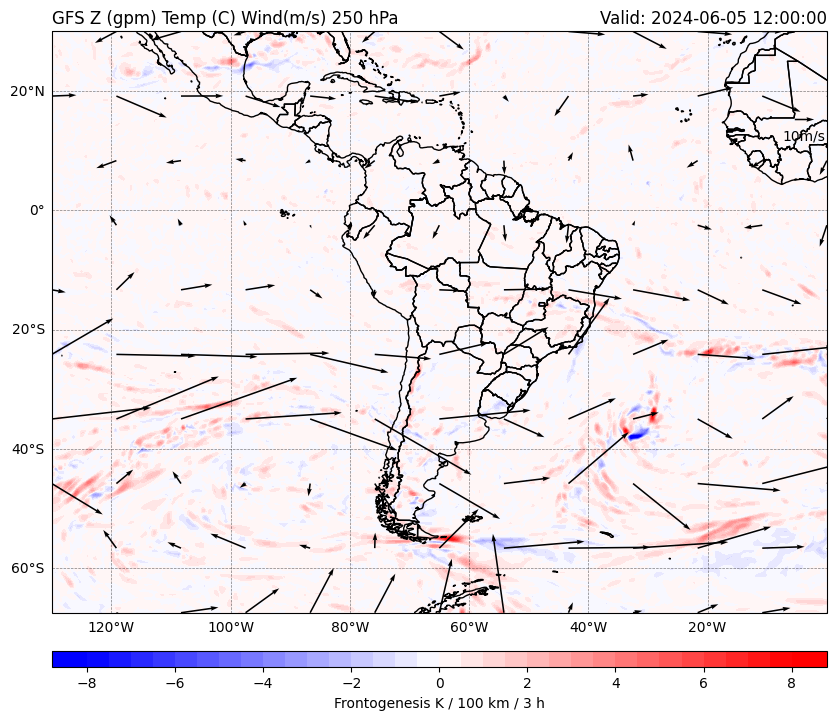

In [23]:
# Create the figure FRONTOGENESE
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=datacrs)

# Add mapping information
# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
ax.set_extent([lon_o, lon_l, lat_sul, lat_norte], ccrs.PlateCarree())

# Plot 850-hPa Frontogenesis
clevs_tmpc = np.arange(-30, 41, 3)
cf = ax.contourf(lon, lat, fronto*convert_to_per_100km_3h, np.arange(-8, 8.5, 0.5),
                 cmap=plt.cm.bwr, extend='both', transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50, extendrect=True)
cb.set_label('Frontogenesis K / 100 km / 3 h')

# Plot 850-hPa Temperature in Celsius
csf = ax.contour(lon, lat, tmpc, clevs_tmpc, colors='grey',
                 linestyles='dashed', transform=datacrs)
plt.clabel(csf, fmt='%d')

# 850-hPa jet
#clevjet = np.arange(15,36,5)
#jet850 = ax.contour(lon, lat, speed_jet, clevjet, cmap='Blues', transform=datacrs)
#plt.colorbar(jet850, orientation='horizontal', pad=0.05, aspect=50, extendrect=True)

# Plot 850-hPa Geopotential Heights
clevs_850_hght = np.arange(0, 8000, 30)
cs = ax.contour(lon, lat, Z, clevs_850_hght, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot Z
#ax.set_extent([lon_o, lon_l, lat_sul, lat_norte], ccrs.PlateCarree())
#cs = ax.contour(lon, lat,Z, clevz, colors='black', linewidths=1.0,linestyles='solid',transform=ccrs.PlateCarree())
#ax.clabel(cs, fontsize=12, colors='black', inline=1, inline_spacing=8,
#          fmt='%i', rightside_up=True, use_clabeltext=True)


uv = ax.quiver(lon, lat, U_nivel, V_nivel, color='black',regrid_shape=10,
          width=0.002, scale = 400, transform=ccrs.PlateCarree())
#Draw the wind field, and after the arrow shaft, you have to explain the relationship between the length of the shaft and the wind speed
#Calling quiver can generate reference arrow + label.
ax.quiverkey(uv,                     #Incoming quiver handle
             X=0.97, Y = 0.85,       #Determine the location of label, all limited to [0,1]
             U = 10,                    #Reference arrow length means the wind speed is 5m/s.
             angle = 0,            #Reference arrow placement angle. The default is 0, which means horizontal placement
             label='10m/s',        #Arrow's supplement: label's content +
             labelpos='S',          #label is in which direction of the reference arrow; S means south
             color = 'black',labelcolor = 'black', #Arrow color + label color
             )
#ax.streamplot(lon, lat, U_nivel, V_nivel, density=[0.5, 1],color='red', linewidth=1, cmap='autumn')
ax.set_title(f'GFS Z (gpm) Temp (C) Wind(m/s) {nivel} hPa ', loc='left')
ax.set_title('Valid: {}'.format(vtime[0]), loc='right')

# Adding grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.top_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlines = True

# Salva o grafico no disco
#plt.savefig("850_z_te.png", dpi=600, bbox_inches="tight")

**12. Criar mapa de advecção de temperatura**

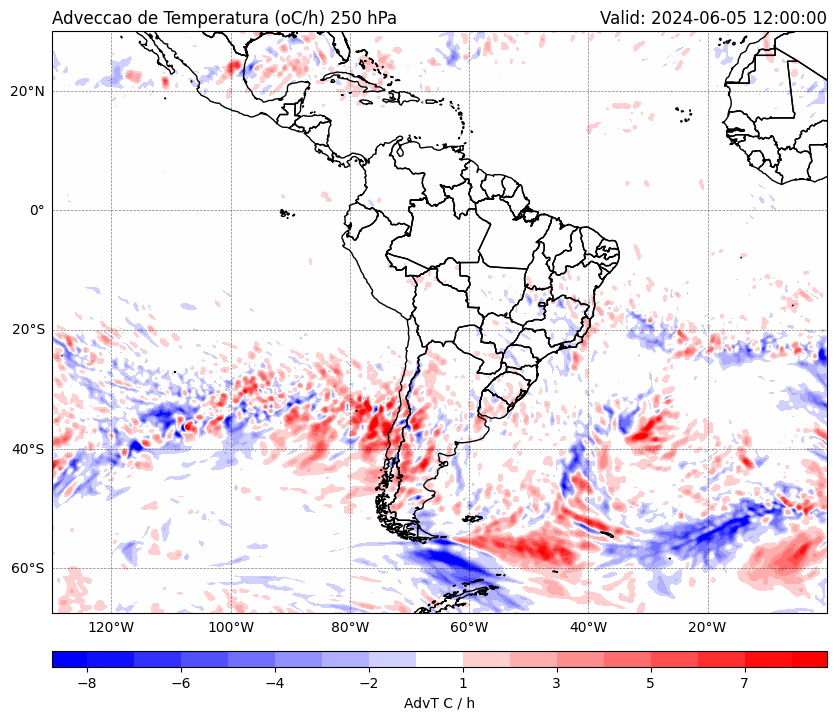

In [25]:
# Create the figure ADVECCAO TEMPERATURA
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=datacrs)

lat_sul = -67.5 #-70
lat_norte = 30 #-15
lon_leste = 360
lon_oeste = 230
lon_l = lon_leste - 360
lon_o = lon_oeste - 360

# Add mapping information
# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
ax.set_extent([lon_o, lon_l, lat_sul, lat_norte], ccrs.PlateCarree())

# Plot Height Contours
clev850 = np.arange(900, 3000, 30)
cs = ax.contour(lon, lat, Z, clev850, colors='black', linewidths=1.0,
                linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Temperature Contours
clevtemp850 = np.arange(-30, 31, 3)
cs2 = ax.contour(lon, lat, T.to(units('degC')), clevtemp850,
                 colors='grey', linewidths=1.0, linestyles='dashed',
                 transform=datacrs)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Colorfill of Temperature Advection
cint = np.arange(-8, 9)
cf = ax.contourf(lon, lat, 3*adv.to(units('delta_degC/hour')), cint[cint != 0],
                 extend='both', cmap='bwr', transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50, extendrect=True)
cb.set_label('AdvT C / h')


#uv = ax.quiver(lon, lat, U_nivel, V_nivel, color='black',regrid_shape=13,
#          width=0.002, scale = 400, transform=ccrs.PlateCarree())
#Draw the wind field, and after the arrow shaft, you have to explain the relationship between the length of the shaft and the wind speed
#Calling quiver can generate reference arrow + label.
#ax.quiverkey(uv,                     #Incoming quiver handle
#             X=0.97, Y = 0.85,       #Determine the location of label, all limited to [0,1]
#             U = 15,                    #Reference arrow length means the wind speed is 5m/s.
#             angle = 0,            #Reference arrow placement angle. The default is 0, which means horizontal placement
#             label='15m/s',        #Arrow's supplement: label's content +
#             labelpos='S',          #label is in which direction of the reference arrow; S means south
#             color = 'black',labelcolor = 'black', #Arrow color + label color
#             )
#ax.streamplot(lon, lat, U_nivel, V_nivel, density=[0.5, 1],color='red', linewidth=1, cmap='autumn')
ax.set_title(f'Adveccao de Temperatura (oC/h) {nivel} hPa ', loc='left')
ax.set_title('Valid: {}'.format(vtime[0]), loc='right')

# Adding grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.top_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlines = True

# Salva o grafico no disco
#plt.savefig("850_z_te.png", dpi=600, bbox_inches="tight")

**13. Criar mapa de vorticidade**

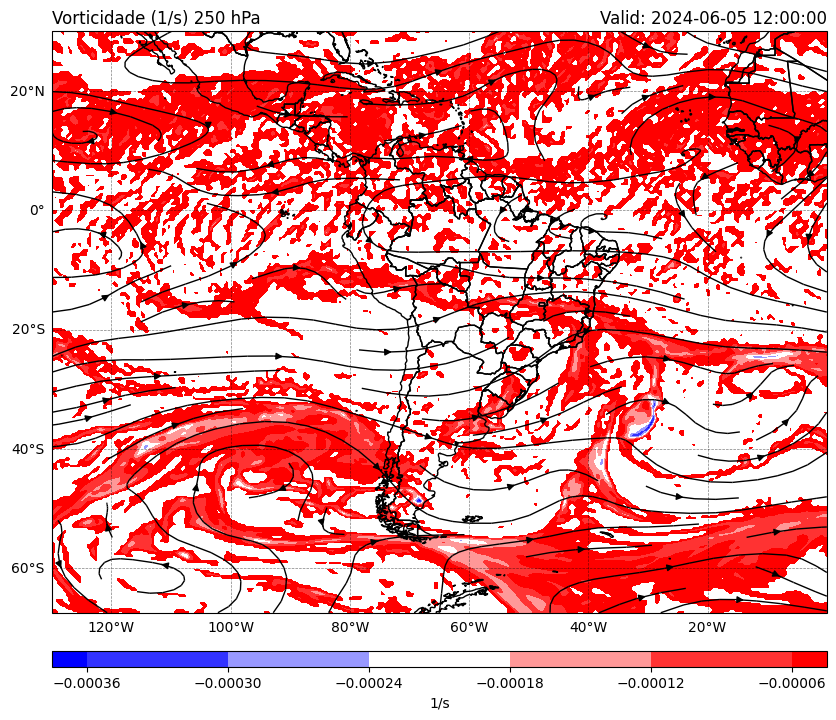

In [26]:
# Create the figure ADVECCAO TEMPERATURA
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=datacrs)

lat_sul = -67.5 #-70
lat_norte = 30 #-15
lon_leste = 360
lon_oeste = 230
lon_l = lon_leste - 360
lon_o = lon_oeste - 360

# Add mapping information
# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
ax.set_extent([lon_o, lon_l, lat_sul, lat_norte], ccrs.PlateCarree())

# Plot Height Contours
clev850 = np.arange(900, 3000, 30)
cs = ax.contour(lon, lat, Z, clev850, colors='black', linewidths=1.0,
                linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Temperature Contours
clevtemp850 = np.arange(-30, 31, 3)
cs2 = ax.contour(lon, lat, T.to(units('degC')), clevtemp850,
                 colors='grey', linewidths=1.0, linestyles='dashed',
                 transform=datacrs)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Colorfill of Temperature Advection
cf = ax.contourf(lon, lat, zeta_nivel,
                 extend='both', cmap='bwr', transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50, extendrect=True)
cb.set_label('1/s')

#uv = ax.quiver(lon, lat, U_nivel, V_nivel, color='black',regrid_shape=13,
#          width=0.002, scale = 400, transform=ccrs.PlateCarree())
#Draw the wind field, and after the arrow shaft, you have to explain the relationship between the length of the shaft and the wind speed
#Calling quiver can generate reference arrow + label.
#ax.quiverkey(uv,                     #Incoming quiver handle
#             X=0.97, Y = 0.85,       #Determine the location of label, all limited to [0,1]
#             U = 15,                    #Reference arrow length means the wind speed is 5m/s.
#             angle = 0,            #Reference arrow placement angle. The default is 0, which means horizontal placement
#             label='15m/s',        #Arrow's supplement: label's content +
#             labelpos='S',          #label is in which direction of the reference arrow; S means south
#             color = 'black',labelcolor = 'black', #Arrow color + label color
#             )

ax.streamplot(lon, lat, U_nivel, V_nivel, density=[0.5, 1],color='black', linewidth=1, cmap='autumn')
ax.set_title(f'Vorticidade (1/s) {nivel} hPa ', loc='left')
ax.set_title('Valid: {}'.format(vtime[0]), loc='right')

# Adding grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.top_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlines = True

# Salva o grafico no disco
#plt.savefig("850_z_te.png", dpi=600, bbox_inches="tight")

**14. Adevecção de vorticidade**

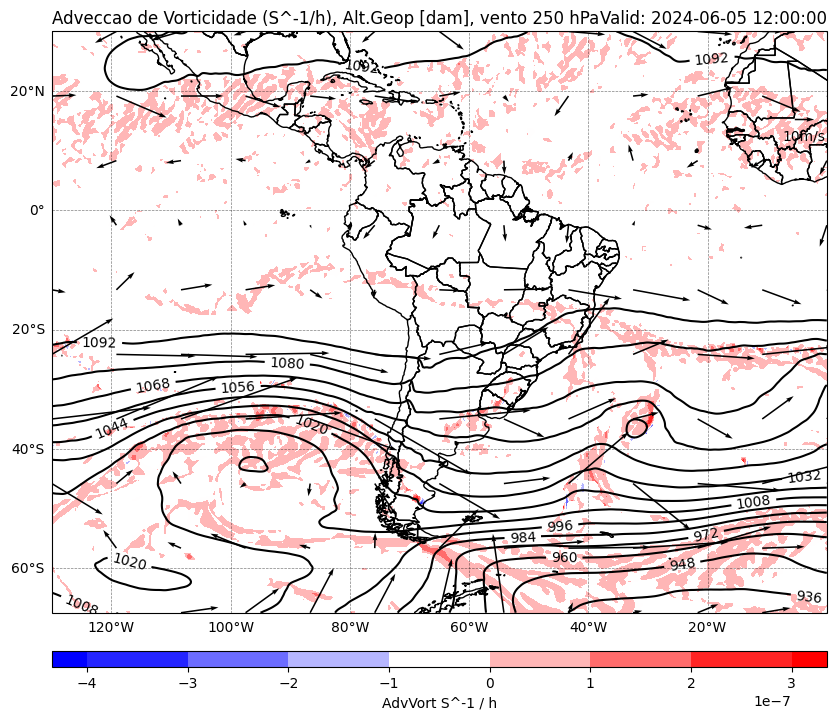

In [27]:
# Create the figure ADVECCAO DE VORTICIDADE
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=datacrs)

lat_sul = -67.5 #-70
lat_norte = 30 #-15
lon_leste = 360
lon_oeste = 230
lon_l = lon_leste - 360
lon_o = lon_oeste - 360

# Add mapping information
# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
ax.set_extent([lon_o, lon_l, lat_sul, lat_norte], ccrs.PlateCarree())

# Plot Height Contours
clev850 = np.arange(900, 3000, 30)
cs = ax.contour(lon, lat, Z, clev850, colors='black', linewidths=1.0,
                linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

'''
# Plot Temperature Contours
clevtemp850 = np.arange(-30, 31, 3)
cs2 = ax.contour(lon, lat, T.to(units('degC')), clevtemp850,
                 colors='grey', linewidths=1.0, linestyles='dashed',
                 transform=datacrs)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)
'''

# Plot Colorfill of Temperature de vorticidade
cint = np.arange(-8, 9)
#cf = ax.contourf(lon, lat, 3*advzeta, cint[cint != 0],
#                 extend='both', cmap='bwr', transform=datacrs)
cf = ax.contourf(lon, lat, 3*advzeta,
                 extend='both', cmap='bwr', transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50, extendrect=True)
cb.set_label('AdvVort S^-1 / h')

# Plot 850-hPa Geopotential Heights
clevs_850_hght = np.arange(0, 2000, 12)
cs = ax.contour(lon, lat, Z/10, clevs_850_hght, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot Z
#ax.set_extent([lon_o, lon_l, lat_sul, lat_norte], ccrs.PlateCarree())
#cs = ax.contour(lon, lat,Z, clevz, colors='black', linewidths=1.0,linestyles='solid',transform=ccrs.PlateCarree())
#ax.clabel(cs, fontsize=12, colors='black', inline=1, inline_spacing=8,
#          fmt='%i', rightside_up=True, use_clabeltext=True)


uv = ax.quiver(lon, lat, U_nivel, V_nivel, color='black',regrid_shape=10,
          width=0.002, scale = 400, transform=ccrs.PlateCarree())
#Draw the wind field, and after the arrow shaft, you have to explain the relationship between the length of the shaft and the wind speed
#Calling quiver can generate reference arrow + label.
ax.quiverkey(uv,                     #Incoming quiver handle
             X=0.97, Y = 0.85,       #Determine the location of label, all limited to [0,1]
             U = 10,                    #Reference arrow length means the wind speed is 5m/s.
             angle = 0,            #Reference arrow placement angle. The default is 0, which means horizontal placement
             label='10m/s',        #Arrow's supplement: label's content +
             labelpos='S',          #label is in which direction of the reference arrow; S means south
             color = 'black',labelcolor = 'black', #Arrow color + label color
             )

#ax.streamplot(lon, lat, U_nivel, V_nivel, density=[0.5, 1],color='red', linewidth=1, cmap='autumn')
ax.set_title(f'Adveccao de Vorticidade (S^-1/h), Alt.Geop [dam], vento {nivel} hPa', loc='left')
ax.set_title('Valid: {}'.format(vtime[0]), loc='right')

# Adding grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.top_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlines = True

# Salva o grafico no disco
#plt.savefig("850_z_te.png", dpi=600, bbox_inches="tight")

##